In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
def save_notebook():
    return display(Javascript("IPython.notebook.save_notebook()"),
                   include=['application/javascript'])

def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [3]:
import sys, os
import glob
import warnings
from itertools import cycle
sys.path.append('../')

from rankutils.evaluation import comp_precision, comp_recall, interp_prec_recall_curve
from rankutils.cfgloader import cfgloader

from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import mpld3
#sns.set()

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange

pmarkers = cycle(['o', 'v', '^', 'p', 'P', '*', 'h', 'D', 'x'])

np.set_printoptions(suppress=True, precision=3, linewidth=300, formatter=dict(float="{0:0.4f}"))

In [4]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    if val < 0:
        color = 'red' 
    elif val > 0:
        color = 'blue'
    else:
        color = 'black'
    return 'color: %s' % color

In [5]:
def make_header_label(header):
    
    dataset = header['dataset']
    method = header['method']
    topn = header['topn']
    k = header['k']
    label = header['labelfolder']
    phi = header['phi']
    balance = header['balance']
    
    prefix = "{0:s} {1:s}".format(dataset, method)
    if len(str(method).split('_')) > 1:        
        label = "{0:25s} [{1:s}][n = {2:03d} | k = {3:03d} | phi = {4:0.2f}".format(prefix, label, topn, k, phi)
        if balance:
            label += " | b = {0:d}".format(balance)
        label += "]"
        
    else:
        label = "{0:25s} [n = {1:03d}]".format(prefix, topn)
    
    return label

In [6]:
def eval_elp_precision_recall(labels, k):
    
    assert labels.shape[1] >= k, "The number of positions labeled for each rank <{0:d}> should be >= k <{1:d}>".format(labels.shape[1], k)
    
    elp_rec = np.arange(0.0, 1.1, 0.1)
    elp_prec_all = []
    ap_all = np.zeros(labels.shape[0], dtype=np.float64)

    for i, row in enumerate(labels):
        
        y_true = row[0:k]
        
        if y_true.sum() > 0:

            prec = comp_precision(y_true)
            rec = comp_recall(y_true)

            elp_prec_all.append(interp_prec_recall_curve(prec, rec, points=elp_rec))

            ap_all[i] = average_precision_score(y_true, np.arange(y_true.size, 0, -1))
        else:
            aux = np.zeros(11, dtype=np.float64)
            aux[0] = 1.0
            elp_prec_all.append(aux)

    elp_prec_all = np.vstack(elp_prec_all)

    mean_elp_prec = np.mean(elp_prec_all, axis=0)
    
    return mean_elp_prec, np.mean(ap_all), ap_all

In [7]:
def load_pathlists(collection, get_bsl=[]):
    
    # Baseline Labels
    bsl_labeldir = '/home/alberto/phD/projects/performance_prediction/ret-mr-learning/input-labels/2x5-fold/{0:s}/'.format(collection)
    aux = glob.glob(bsl_labeldir + "*.npy")
    aux.sort()
    if get_bsl:
        bsl_labelpaths = []
        for i in get_bsl:
            bsl_labelpaths.append(aux[i])
    else:
        bsl_labelpaths = aux

    # Aggregated Labels
    agg_labeldir = '/home/alberto/phD/projects/performance_prediction/ret-mr-learning/output-agg/eval/'.format(collection)
    agg_labelpaths = glob.glob(agg_labeldir + "*.npz")
    agg_labelpaths.sort()
    
    return bsl_labelpaths, agg_labelpaths

In [8]:
def labeled_rerank(labels, final_pos=1, order=np.array([])):

    if order.size == 0:
        order = np.arange(labels.shape[0])

    i = labels.shape[0] - 1

    while i > final_pos:

        label_a = labels[i]
        label_b = labels[i-1]

        if label_a > label_b:
            order[i-1], order[i] = order[i], order[i-1]
            i -= 2
        else:
            i -= 1

    return order

In [9]:
topk = 50
collection = 'places365'
order = 1
key = "{0:s}_{1:03d}".format(collection, order)

leg_name_map = dict()

np.set_printoptions(precision=3, suppress=True)

pathcfg = cfgloader('/home/alberto/phD/projects/performance_prediction/ret-mr-learning/source/path_2.cfg')

rktpdir = pathcfg.get(key, 'rktpdir')

gtpath = glob.glob("{0:s}*{1:s}*".format(pathcfg.get(key, 'label'), rktpdir))[0]
gtlabels = np.load(gtpath)[:, 0:topk]

probpath = glob.glob("{0:s}{1:s}/prob0009/*{2:s}*".format(pathcfg.get('DEFAULT', 'agglbldir'), collection, rktpdir))[0]
pprob = np.load(probpath)[:, 0:topk]

In [10]:
rrlabels = np.zeros(gtlabels.shape, dtype=np.uint8)

rr_2_labels = np.zeros(gtlabels.shape, dtype=np.uint8)

for i in range(gtlabels.shape[0]):
    
    g = gtlabels[i]
    p = pprob[i]
    
    reorder = np.argsort(p)[::-1]
    
    rrlabels[i] = g[reorder]
    
    reorder = labeled_rerank(p, final_pos=1, order=np.array([]))
    
    rr_2_labels[i] = g[reorder]
    
mean_elp_prec_gt, mAP_gt, ap_all_gt = eval_elp_precision_recall(gtlabels, topk)
mean_elp_prec_rr, mAP_rr, ap_all_rr = eval_elp_precision_recall(rrlabels, topk)
mean_elp_prec_rr_2, mAP_rr_2, ap_all_rr_2 = eval_elp_precision_recall(rrlabels, topk)

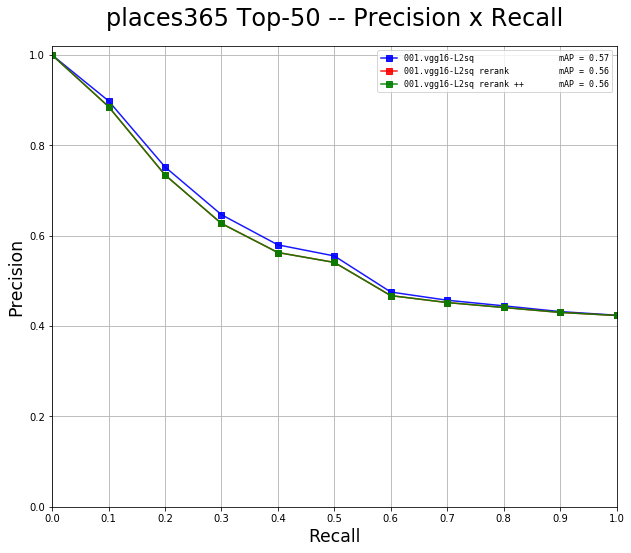

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 8)
fig.tight_layout()

x = np.arange(0.0, 1.1, 0.1)

ax.plot(x, mean_elp_prec_gt, '-s', color='blue', label="{0:30s} mAP = {1:0.2f}".format(rktpdir, mAP_gt), alpha=0.9)
ax.plot(x, mean_elp_prec_rr, '-s', color='red', label="{0:30s} mAP = {1:0.2f}".format(rktpdir + ' rerank', mAP_rr), alpha=0.9)
ax.plot(x, mean_elp_prec_rr_2, '-s', color='green', label="{0:30s} mAP = {1:0.2f}".format(rktpdir + ' rerank ++', mAP_rr_2), alpha=0.9)

ax.set_xlim(0.0, 1.0)
ax.set_xlabel('Recall', **dict(fontsize='xx-large'))
ax.set_xticks(np.arange(0.0, 1.1, 0.1))

ax.set_ylim(0.0, 1.02)
ax.set_ylabel('Precision', **dict(fontsize='xx-large'))

ax.grid(which='both', axis='both')

ax.set_title('{0:s} Top-{1:d} -- Precision x Recall'.format(collection, topk), **dict(fontsize=24), pad=20)

legend = ax.legend(prop={'family':'monospace', 'size':'small'})

plt.subplots_adjust(left=0.1, top=0.9, bottom=0.1)